# import needed libraries 

In [1]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 89 kB 7.6 MB/s 


In [4]:
import nltk
nltk.download('all')
  

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

True

In [5]:
import pandas as pd 
import matplotlib as plt
from nltk.corpus import stopwords,reuters
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score , classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, hamming_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import re
import string

# Represent train and test docs


In [6]:
#extracting train and test documents
#train_documents
train_docs_id = list(filter(lambda doc: doc.startswith("train"),reuters.fileids()));
train_docs = [reuters.raw(doc_id) for doc_id in train_docs_id]
print('Number of docs in the train set: ' + str(len(train_docs)))
#test_documents
test_docs_id = list(filter(lambda doc: doc.startswith("test"),reuters.fileids()));
test_docs = [reuters.raw(doc_id) for doc_id in test_docs_id]
print('Number of docs in the test set: ' + str(len(test_docs)))

Number of docs in the train set: 7769
Number of docs in the test set: 3019


# Cleaning Documents


In [7]:
codes = ['\r', '\n', '\t','lt']
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower() #Make text lowercase
    text = re.sub('\[.*?\]', '',str(text))
    text = re.sub('[%s]' % re.escape(string.punctuation), '', str(text)) #remove punctuation
    text = re.sub('\w*\d\w*', '', str(text)) #remove words containing numbers
    text = re.sub('[‘’“”…]', '', str(text))
    text = re.sub(r'dlrs', 'dollar', text)  # replace dlrs abreviation 
    text = re.sub(r'pct', 'percent', text)  # replace pct abreviation  
    for code in codes:
        text = re.sub(code, ' ', text)  # get rid of escape codes
    text = re.sub('\s+', ' ', text) # replace multiple spacess with one space   
    return text

In [8]:
#cleaning training and testing documents
cleaned_train_documents = []
for i in range(0,len(train_docs)):    
    cleaned_train_documents.append(clean_text(str(train_docs[i])))
cleaned_test_documents = []
for i in range(0,len(test_docs)):    
    cleaned_test_documents.append(clean_text(str(test_docs[i])))

# Tokenization 


In [9]:
lemmatizer = WordNetLemmatizer()

def toknize(text):
    stop_words = set(stopwords.words("english"))
    tokens = word_tokenize(text) #split document into individual words(tokens)
    tokens= [word for word in tokens if word not in stop_words] #filter out stop words if requested
    tokens = [word for word in tokens if word.isalpha()] #remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if len(word) > 2] #filter out tokens that are one or two characters long
    tokens = [word for word in tokens if len(word) < 21] # filter out tokens that are more than twenty characters long
    lemmas= [lemmatizer.lemmatize(word) for word in tokens] #apply word lemmatization
    # recreate the document string from parsed words
    text = ''
    for lema in lemmas:
        text = text + ' ' + lema
    return tokens,text

In [10]:
train_text = [] # list of document strings for sklearn TF-IDF
train_tokens = []  # list of token lists
for doc in cleaned_train_documents:
    text_string = doc
    # parse words one at a time in document string
    tokens,text_string = toknize(text_string)
    train_tokens.append(tokens)
    train_text.append(text_string)

In [11]:
test_tokens = []  # list of token lists
test_text = [] # list of document strings for sklearn TF-IDF
for doc in cleaned_test_documents:
    text_string = doc
    # parse words one at a time in document string
    tokens,text_string = toknize(text_string)
    test_tokens.append(text_string)
    test_text.append(text_string)

# Applying (TF-IDF vectorizer)


In [12]:
# Learn and transform train documents
vectorizer = TfidfVectorizer(tokenizer=word_tokenize)
vectorised_train_documents = vectorizer.fit_transform(train_text)
# transform test documents
vectorised_test_documents = vectorizer.transform(test_text)
feature_names= vectorizer.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [13]:
#transform the sparse matrix to dense matrix and creat Daraframe of feature space  
train_vectors_df= pd.DataFrame(vectorised_train_documents.todense(), columns = feature_names)
train_vectors_df.head()

,aa,aaa,aac,aachener,aagiy,aaix,aaminus,aancor,aap,aaplus,...,zorinsky,zseven,zuccherifici,zuckerman,zulia,zurich,zurichbased,zuyuan,zverev,zzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
#transform the sparse matrix to dense matrix and creat Daraframe of feature space  
test_vectors_df= pd.DataFrame(vectorised_test_documents.todense(), columns = feature_names)
test_vectors_df.head()

,aa,aaa,aac,aachener,aagiy,aaix,aaminus,aancor,aap,aaplus,...,zorinsky,zseven,zuccherifici,zuckerman,zulia,zurich,zurichbased,zuyuan,zverev,zzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# create the PCA instance
pca_out = PCA(0.95)
# fit on data
x_train=pca_out.fit_transform(train_vectors_df)
# access values and vectors
print(pca_out.components_)
print(pca_out.explained_variance_)

[[-2.25070211e-05 -9.52596707e-05 -4.09824437e-05 ... -1.57275179e-05
  -6.92610161e-05  4.75378227e-04]
 [-2.23497464e-05 -8.70725040e-05 -1.00694540e-04 ... -1.44487673e-05
  -1.80336104e-06  1.10334557e-04]
 [ 8.91208872e-05  3.79033976e-05 -1.75005450e-04 ...  2.27354366e-05
   6.64885669e-05 -1.12356348e-03]
 ...
 [-1.01699632e-03  7.98446567e-03  4.38606826e-03 ... -2.01834179e-03
  -1.95820765e-03  2.36803211e-02]
 [-1.79913719e-03 -2.80828922e-03 -4.11766295e-03 ... -7.56473485e-04
  -9.92851672e-04 -5.58065180e-03]
 [ 1.02792968e-03  1.12823481e-02 -2.68840994e-03 ...  1.23773082e-03
   3.86799840e-03 -1.60439983e-02]]
[4.50074557e-02 1.82503092e-02 1.42885437e-02 ... 3.53067824e-05
 3.52992956e-05 3.52565231e-05]


In [16]:
x_test=pca_out.transform(test_vectors_df)


In [17]:
x_test.shape

(3019, 4120)

In [18]:
print('Explained variation per principal component: {}'.format(pca_out.explained_variance_ratio_))


Explained variation per principal component: [4.69587517e-02 1.90415504e-02 1.49080228e-02 ... 3.68375062e-05
 3.68296949e-05 3.67850679e-05]


In [19]:
#the propotion of variance each principal component holds after projecting the data to a lower dimensional subspace.
print(sum(pca_out.explained_variance_ratio_))

0.950036168198632


In [20]:
#creating dataframe that show the pcs that contain the most important and varient data 
loadings = pca_out.components_
num_pc = pca_out.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = train_vectors_df.columns.values
loadings_df = loadings_df.set_index('variable')
loadings_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC4111,PC4112,PC4113,PC4114,PC4115,PC4116,PC4117,PC4118,PC4119,PC4120
variable,,,,,,,,,,,,,,,,,,,,,
aa,-0.000023,-0.000022,0.000089,-0.000055,0.000035,-0.000020,0.000006,-0.000019,-3.649914e-05,-4.443008e-05,...,-0.001483,-0.003249,0.000310,-0.003536,0.000698,0.003263,0.003166,-0.001017,-0.001799,0.001028
aaa,-0.000095,-0.000087,0.000038,0.000093,-0.000194,0.000088,-0.000077,-0.000119,-2.299728e-04,5.052890e-05,...,0.001026,-0.002684,0.004845,0.005793,-0.000191,-0.002517,0.004870,0.007984,-0.002808,0.011282
aac,-0.000041,-0.000101,-0.000175,-0.000246,0.000288,0.000552,-0.000185,0.000256,-8.548512e-07,-3.044345e-04,...,-0.002017,-0.001930,-0.003588,0.000629,-0.004796,0.000829,0.002884,0.004386,-0.004118,-0.002688
aachener,-0.000008,-0.000057,-0.000046,0.000095,0.000006,0.000031,0.000057,0.000062,-9.620118e-05,1.486251e-04,...,0.000880,-0.000796,0.000065,0.001121,0.003664,0.001546,-0.000213,0.001177,-0.000323,0.000945
aagiy,0.000231,0.000440,-0.000720,0.000257,0.000677,0.000124,0.000790,0.000219,9.774248e-05,-3.666396e-04,...,-0.001357,-0.001952,0.010067,-0.005320,-0.004318,0.000480,-0.006243,0.009808,0.000107,0.002935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zurich,-0.000282,-0.000272,0.000156,-0.000544,0.000352,0.000651,-0.000536,0.001339,-7.716910e-04,2.717920e-04,...,0.005083,0.010464,-0.008076,0.001505,-0.001245,0.001632,-0.015362,-0.001359,-0.003279,-0.008629
zurichbased,-0.000020,-0.000006,0.000011,-0.000031,-0.000009,0.000004,-0.000029,0.000120,-4.605682e-05,2.658558e-05,...,0.000841,-0.000289,0.000310,-0.002707,0.000076,-0.000521,0.001451,-0.000498,-0.001004,-0.000504
zuyuan,-0.000016,-0.000014,0.000023,-0.000027,-0.000007,-0.000038,0.000051,-0.000042,3.627473e-05,-3.853138e-06,...,-0.000611,0.000271,0.001352,-0.000318,0.001310,0.001734,-0.000680,-0.002018,-0.000756,0.001238


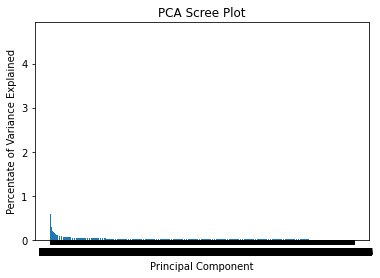

In [21]:
#representing the persentage of data in each component within the gragh 
import matplotlib.pyplot as plt
percent_variance = np.round(pca_out.explained_variance_ratio_* 100,decimals=2)
columns =  ["PC"+str(i) for i in range(1, len(percent_variance)+1)]
plt.bar(x= range(1,len(percent_variance)+1), height=percent_variance, tick_label=columns)
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component')
plt.title('PCA Scree Plot')
plt.show()

Text(0, 0.5, 'PC2')

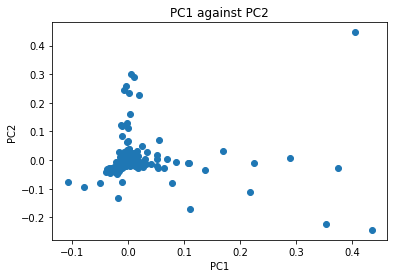

In [22]:
#showing the distribution of data between two pcs
plt.scatter(loadings_df.PC1, loadings_df.PC2)
plt.title('PC1 against PC2')
plt.xlabel('PC1')
plt.ylabel('PC2')

# Transform multilabel labels


In [23]:
#encode multi-label per instance 
mlb = MultiLabelBinarizer()
train_labels = mlb.fit_transform([reuters.categories(doc_id)
for doc_id in train_docs_id])
test_labels = mlb.transform([reuters.categories(doc_id)
for doc_id in test_docs_id])

# Train and Evaluate Classifiers


In [24]:
ModelsPerformance = {}

def metricsReport(modelName, test_labels, predictions):
    accuracy = accuracy_score(test_labels, predictions)

    macro_precision = precision_score(test_labels, predictions, average='macro')
    macro_recall = recall_score(test_labels, predictions, average='macro')
    macro_f1 = f1_score(test_labels, predictions, average='macro')

    micro_precision = precision_score(test_labels, predictions, average='micro')
    micro_recall = recall_score(test_labels, predictions, average='micro')
    micro_f1 = f1_score(test_labels, predictions, average='micro')
    hamLoss = hamming_loss(test_labels, predictions)
    print("------" + modelName + " Model Metrics-----")
    print("Accuracy: {:.4f}\nHamming Loss: {:.4f}\nPrecision:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nRecall:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nF1-measure:\n  - Macro: {:.4f}\n  - Micro: {:.4f}"\
          .format(accuracy, hamLoss, macro_precision, micro_precision, macro_recall, micro_recall, macro_f1, micro_f1))
    ModelsPerformance[modelName] = micro_f1

# Random Forest Classifier

In [25]:
rfClassifier = RandomForestClassifier(n_jobs=-1)
rfClassifier.fit(x_train, train_labels)
rfPreds = rfClassifier.predict(x_test)
metricsReport("Random Forest", test_labels, rfPreds)

------Random Forest Model Metrics-----
Accuracy: 0.4770
Hamming Loss: 0.0084
Precision:
  - Macro: 0.2129
  - Micro: 0.9822
Recall:
  - Macro: 0.0325
  - Micro: 0.3974
F1-measure:
  - Macro: 0.0468
  - Micro: 0.5659


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Decision Tree Classifier

In [26]:
dtClassifier = DecisionTreeClassifier()
dtClassifier.fit(x_train, train_labels)
dtPreds = dtClassifier.predict(x_test)
metricsReport("Decision Tree", test_labels, dtPreds)

------Decision Tree Model Metrics-----
Accuracy: 0.6787
Hamming Loss: 0.0085
Precision:
  - Macro: 0.2648
  - Micro: 0.7007
Recall:
  - Macro: 0.2408
  - Micro: 0.6752
F1-measure:
  - Macro: 0.2427
  - Micro: 0.6877


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Support Vector Machine Classifier 

In [27]:
svmClassifier = OneVsRestClassifier(LinearSVC(), n_jobs=-1)
svmClassifier.fit(x_train, train_labels)

svmPreds = svmClassifier.predict(x_test)
metricsReport("SVC Sq. Hinge Loss", test_labels, svmPreds)

------SVC Sq. Hinge Loss Model Metrics-----
Accuracy: 0.8109
Hamming Loss: 0.0034
Precision:
  - Macro: 0.6489
  - Micro: 0.9456
Recall:
  - Macro: 0.3920
  - Micro: 0.7991
F1-measure:
  - Macro: 0.4645
  - Micro: 0.8662


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
powerSetSVC = LabelPowerset(LinearSVC())
powerSetSVC.fit(x_train, train_labels)

powerSetSVCPreds = powerSetSVC.predict(x_test)
metricsReport("Power Set SVC", test_labels, powerSetSVCPreds)

------Power Set SVC Model Metrics-----
Accuracy: 0.8443
Hamming Loss: 0.0036
Precision:
  - Macro: 0.6849
  - Micro: 0.9052
Recall:
  - Macro: 0.4750
  - Micro: 0.8240
F1-measure:
  - Macro: 0.5288
  - Micro: 0.8627


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
print("  Model Name " + " "*10 + "| Micro-F1 Score")
print("-------------------------------------------")
for key, value in ModelsPerformance.items():
    print("  " + key, " "*(20-len(key)) + "|", value)
    print("-------------------------------------------")

  Model Name           | Micro-F1 Score
-------------------------------------------
  Random Forest        | 0.5658870507701084
-------------------------------------------
  Decision Tree        | 0.6877040261153428
-------------------------------------------
  SVC Sq. Hinge Loss   | 0.8662420382165605
-------------------------------------------
  Power Set SVC        | 0.8626957494407159
-------------------------------------------
